# Synthetic Data Quality Evaluation

In [1]:
# import libraries
import os
os.chdir("..")
import torch
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from torchvision.utils import make_grid
from torchvision import transforms
from matplotlib import pyplot as plt
from utils.data_utils import ImageDataset
import seaborn as sns
from tqdm import tqdm

In [2]:
torch.cuda.empty_cache()

## Load Data

In [3]:
synthetic_dataset_path = "/home/zchayav/projects/stylegan2-ada-pytorch/synthetic_datasets/stylegan2_synthetic_-3perclass/generated_examples2.csv"
real_dataset_path = "/home/zchayav/projects/syntheye/datasets/eye2gene_new_filepaths/all_baf_valid_50deg_filtered_train_0_NOREPEATS.csv"

# add image transforms
tr = transforms.Compose([transforms.Resize((299, 299)), transforms.Grayscale(3), transforms.ToTensor()])

# load csvs
synthetic_dataset = ImageDataset(synthetic_dataset_path, "file.path", "gene", class_vals="classes.txt", transforms=tr, class_mapping="classes_mapping.json")
real_dataset = ImageDataset(real_dataset_path, "file.path", "gene", class_vals="classes.txt", transforms=tr, class_mapping="classes_mapping.json")
synth_dataloader = torch.utils.data.DataLoader(synthetic_dataset, batch_size=128)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=128)

## Feature Space Analysis

In [4]:
# del model_weights, model

# load inceptionv3 trained on real data
from torchvision.transforms import Grayscale
from torchvision.models import inception_v3
model_weights = torch.load("/home/zchayav/projects/syntheye/eye2gene_retraining/inception_model/all_folds_retraining/real_only/best_weights.pth")
# load architecture
model = inception_v3()
model.AuxLogits.fc = torch.nn.Linear(768, 36)
model.fc = torch.nn.Linear(2048, 36)
# load weights
model.load_state_dict(model_weights)
# replace last layer with identity layer
model.fc = torch.nn.Identity()
# add on GPU
model.to("cuda:1")
model.eval()

# get feature maps of all images
real_features = []
synthetic_features = []

for _, _, x, y in tqdm(real_dataloader):
    x = x.to("cuda:1")
    real_features.append(model(x).detach().cpu().numpy())

for _, _, x, y in tqdm(synth_dataloader):
    x = x.to("cuda:1")
    synthetic_features.append(model(x).detach().cpu().numpy())

real_features = np.concatenate(real_features, axis=0)
synthetic_features = np.concatenate(synthetic_features, axis=0)

/home/zchayav/anaconda3/envs/syntheye/lib/python3.8/site-packages/torchvision/models/inception.py:81: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '
100%|██████████| 48/48 [00:38<00:00,  1.26it/s]


## Compute UMAP Embeddings

In [58]:
# embed the real dataset in 2D
def run_dim_reduce(data, n_components=2, method="tsne", transform=False, random_state=1399, **extra_params):
    if method == "umap":
        import umap
        n_neighbours = extra_params["n_neighbors"] if "n_neighbors" in extra_params.keys() else 15
        min_dist = extra_params["min_dist"] if "min_dist" in extra_params.keys() else 0.1
        mapper = umap.UMAP(n_neighbors=n_neighbours, min_dist=min_dist, random_state=random_state, n_components=n_components)
        mapper.fit(data)
    else:
        from sklearn.manifold import TSNE
        print("Fitting Dataset")
        mapper = TSNE(n_components=n_components, init='random', random_state=random_state)
        mapper.fit(data)

    if transform:
        print("Transforming Dataset")
        embeddings = mapper.transform(np.float32(data))

        return (mapper, embeddings)
    else:
        return mapper

In [59]:
# concatenate real and synthetic features 
all_features = np.concatenate([real_features, synthetic_features], axis=0)

# set hyperparameters
n_neighbors = [10, 20, 50, 100, 200]
min_dist = [0, 0.1, 0.5, 0.99]

# run 2d dimensionality reduction algorithm
embeddings = np.zeros((len(n_neighbors), len(min_dist), len(all_features), 2))
for i, n in enumerate(n_neighbors):
    for j, m in enumerate(min_dist):
        print("Nearest Neighbors = {}, Min Dist = {}".format(n, m))
        mapper, embed = run_dim_reduce(all_features, n_components=2, method="umap", transform=True, n_neighbors=n, min_dist=m)
        embeddings[i, j, :, :] = embed
        print("\n")

Nearest Neighbors = 10, Min Dist = 0
Transforming Dataset


Nearest Neighbors = 10, Min Dist = 0.1
Transforming Dataset


Nearest Neighbors = 10, Min Dist = 0.5
Transforming Dataset


Nearest Neighbors = 10, Min Dist = 0.99
Transforming Dataset


Nearest Neighbors = 20, Min Dist = 0
Transforming Dataset


Nearest Neighbors = 20, Min Dist = 0.1
Transforming Dataset


Nearest Neighbors = 20, Min Dist = 0.5
Transforming Dataset


Nearest Neighbors = 20, Min Dist = 0.99
Transforming Dataset


Nearest Neighbors = 50, Min Dist = 0
Transforming Dataset


Nearest Neighbors = 50, Min Dist = 0.1
Transforming Dataset


Nearest Neighbors = 50, Min Dist = 0.5
Transforming Dataset


Nearest Neighbors = 50, Min Dist = 0.99
Transforming Dataset


Nearest Neighbors = 100, Min Dist = 0
Transforming Dataset


Nearest Neighbors = 100, Min Dist = 0.1
Transforming Dataset


Nearest Neighbors = 100, Min Dist = 0.5
Transforming Dataset


Nearest Neighbors = 100, Min Dist = 0.99
Transforming Dataset


Nearest 

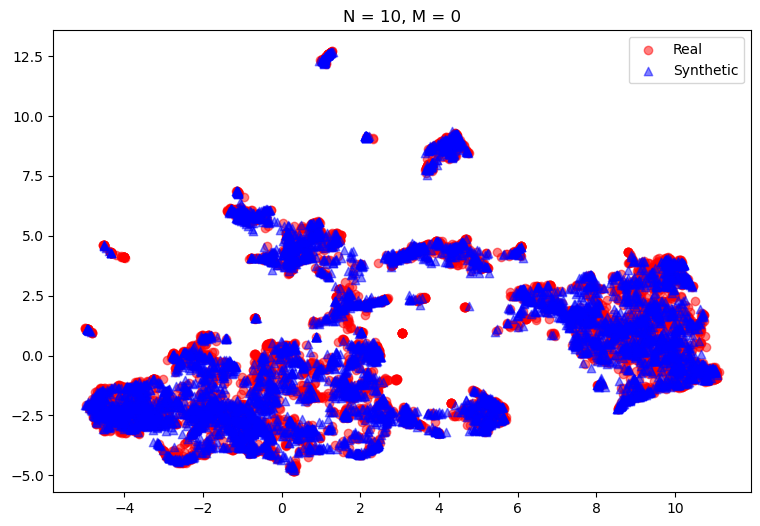

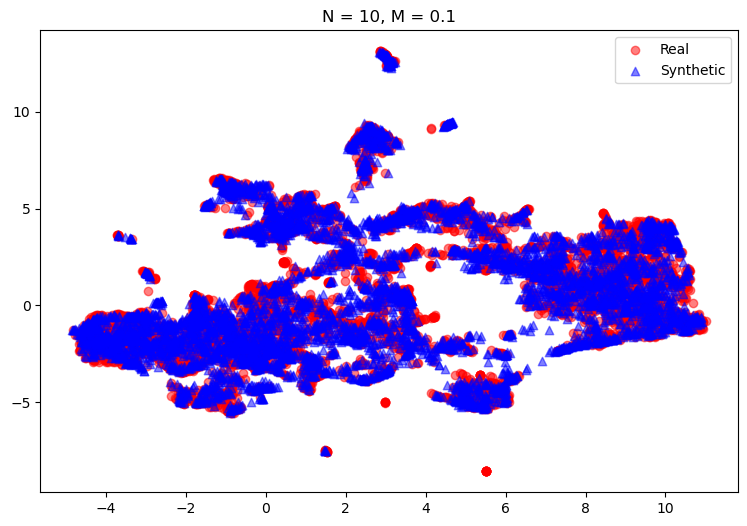

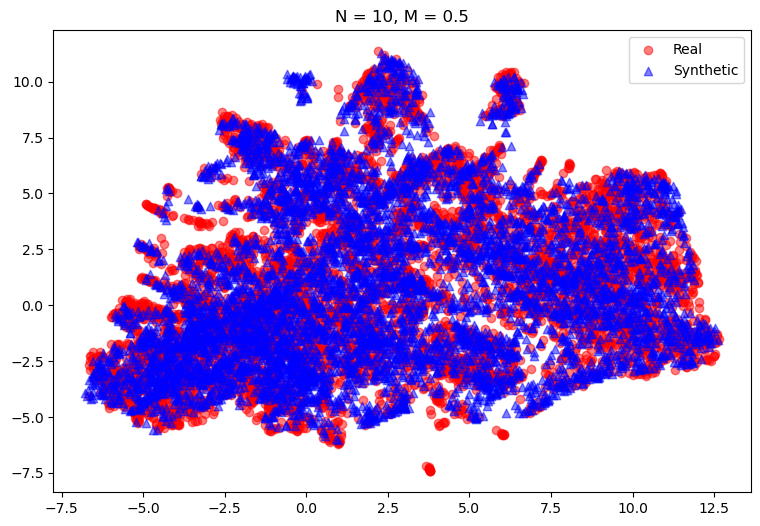

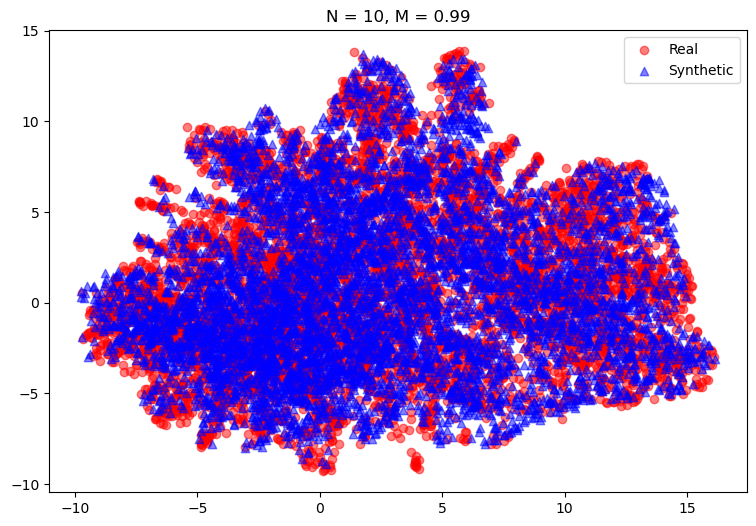

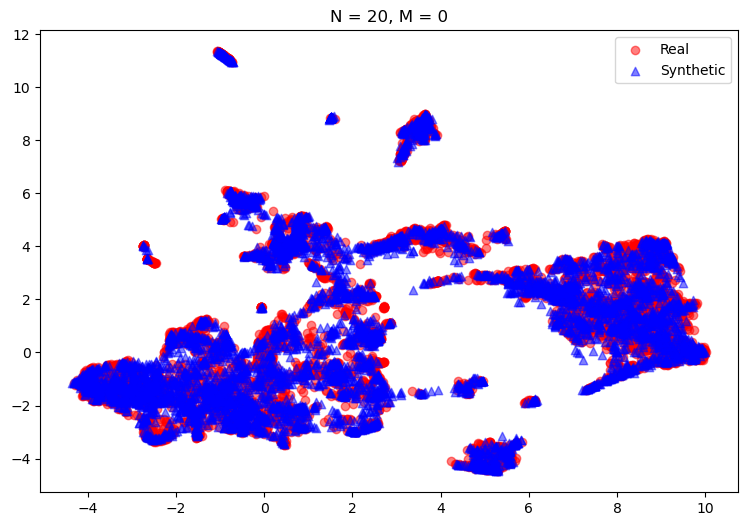

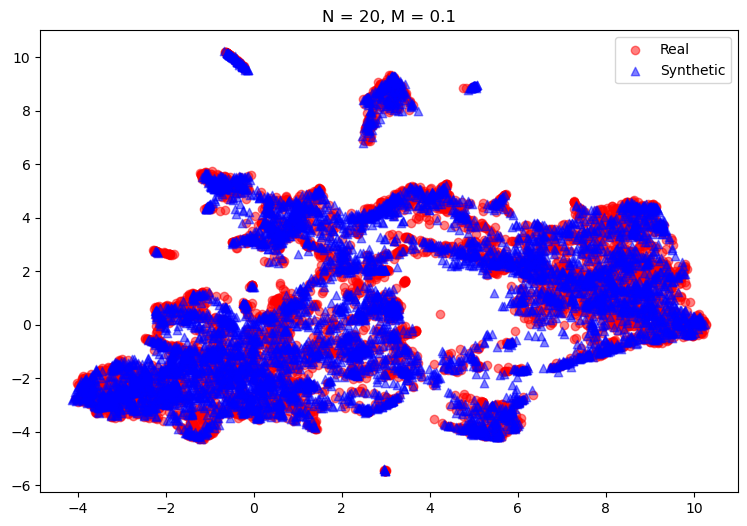

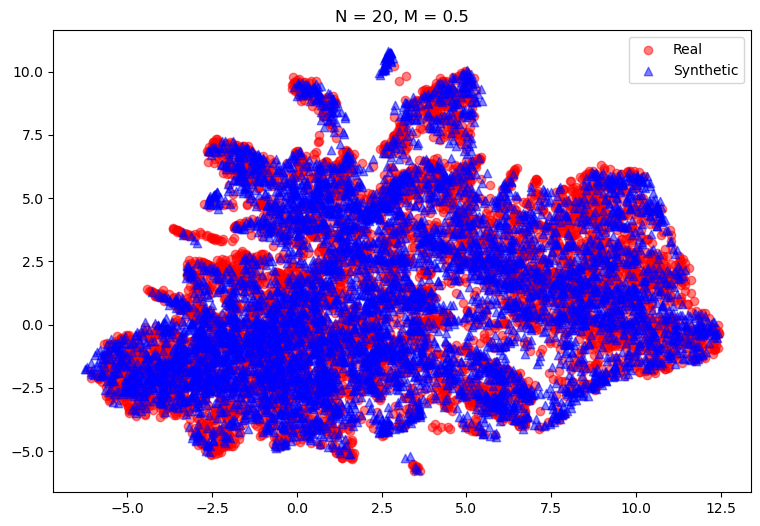

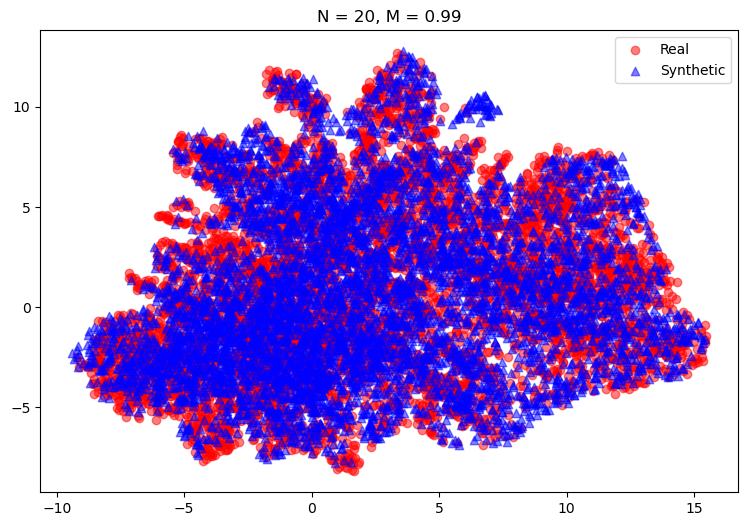

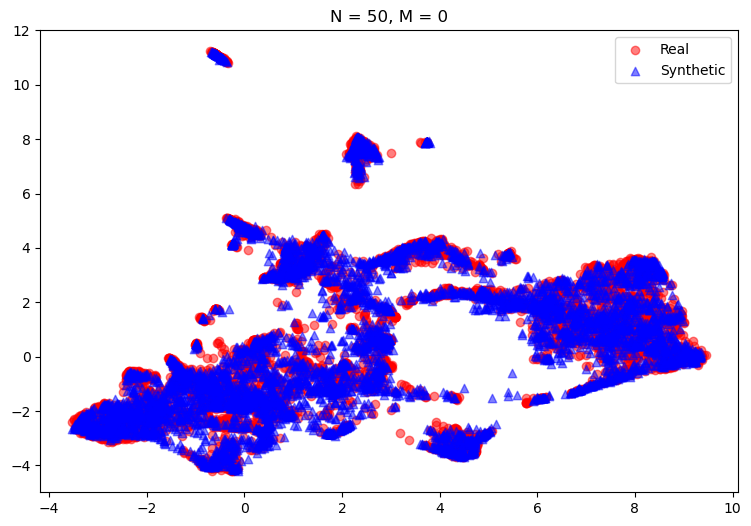

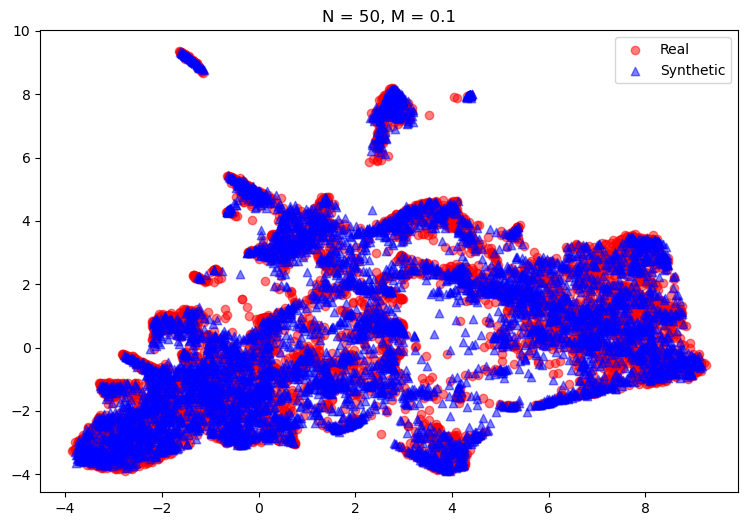

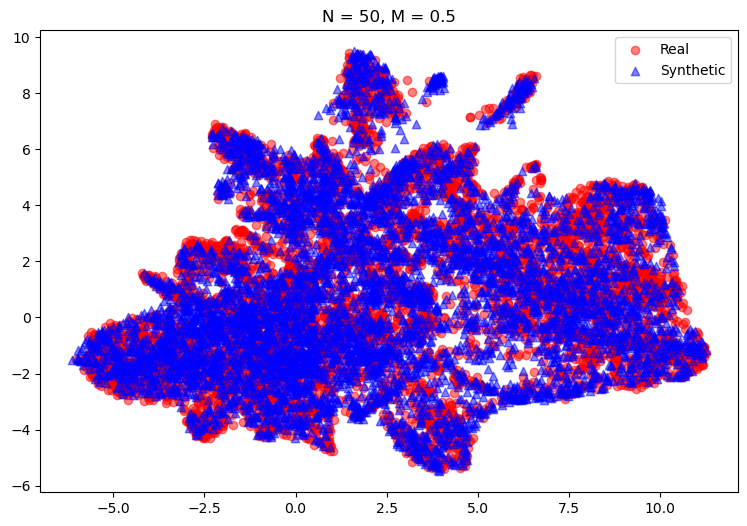

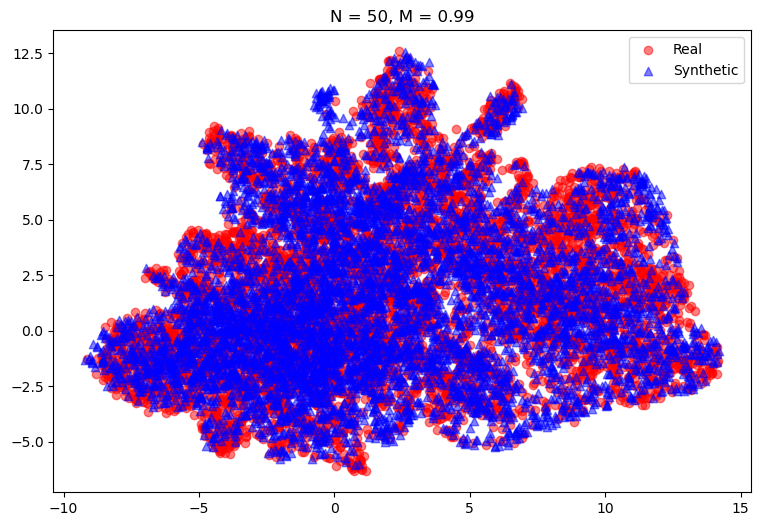

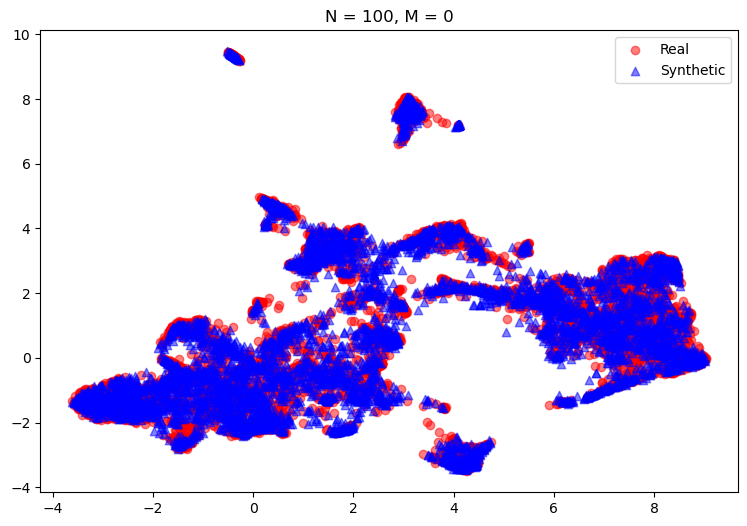

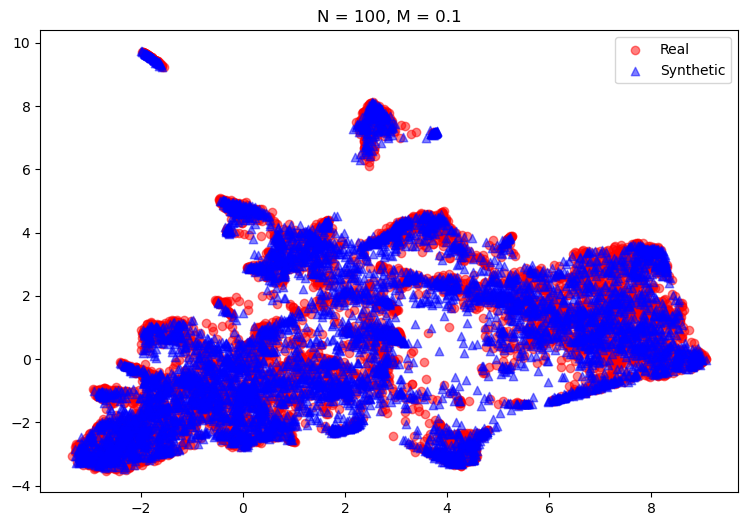

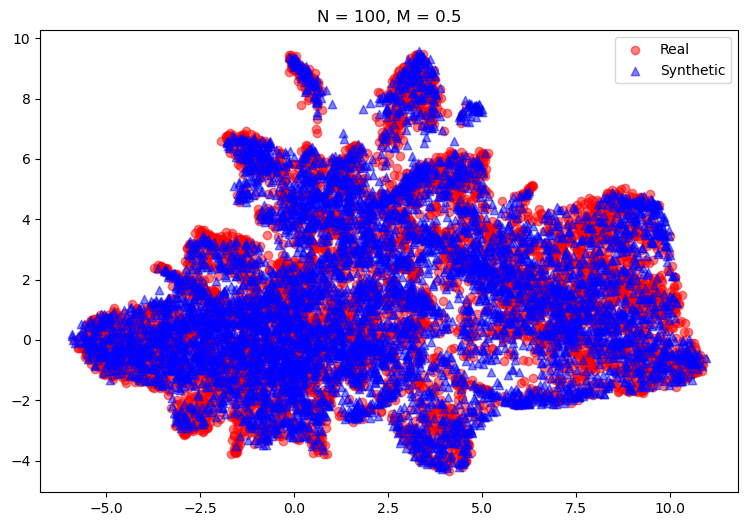

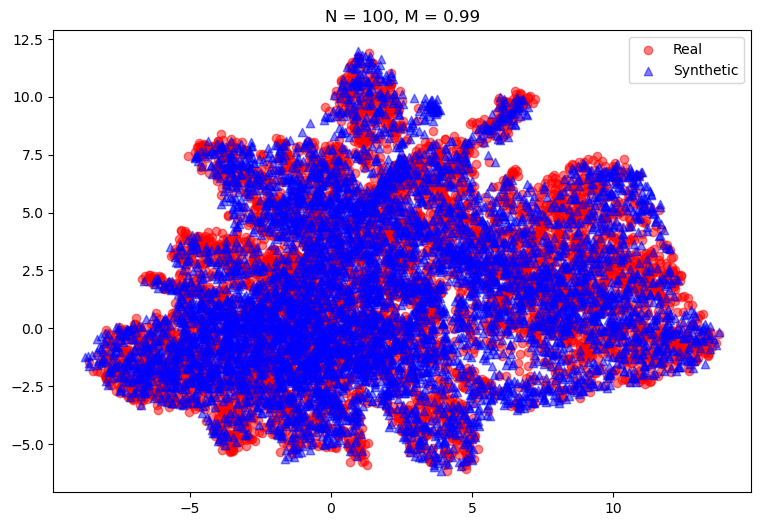

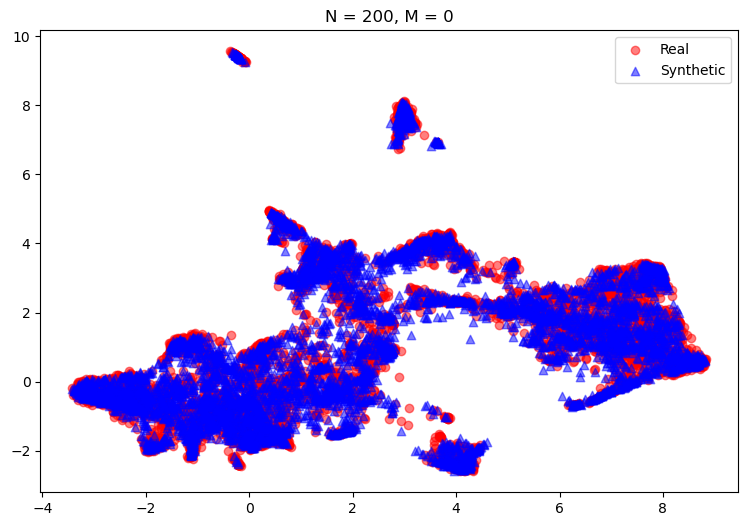

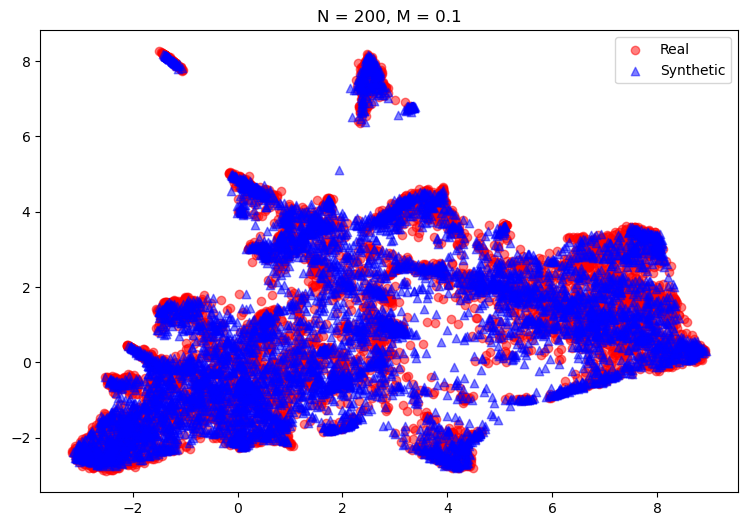

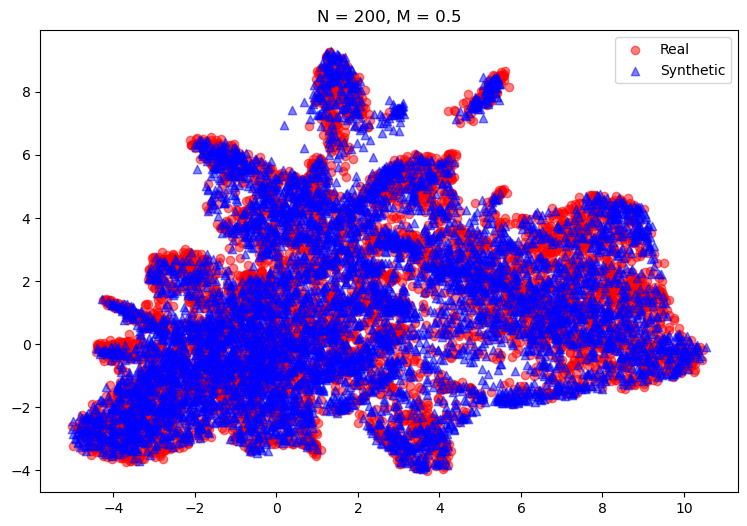

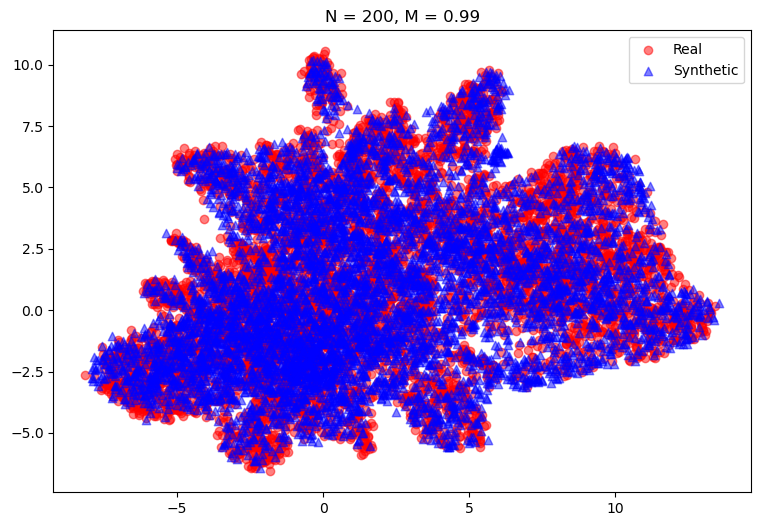

In [60]:
graph_per_class = False

for i, n in enumerate(n_neighbors):
    for j, m in enumerate(min_dist):

        # grab embeddings
        embed = embeddings[i, j]

        # separate into real vs synthetic
        real_embeddings, synthetic_embeddings = embed[:len(real_features)], embed[len(real_features):]
        
        real_labels = np.array([real_dataset.class2idx[i] for i in real_dataset.img_labels])
        synthetic_labels = np.array([synthetic_dataset.class2idx[i] for i in synthetic_dataset.img_labels])
        target_names = list(real_dataset.class2idx.keys())
        target_ids = list(real_dataset.class2idx.values())
        assert len(target_names) == len(target_ids)
        assert real_embeddings.shape[0] == len(real_labels)
        assert synthetic_embeddings.shape[0] == len(synthetic_labels)

        plt.figure(figsize=(9,6))
        plt.title("N = {}, M = {}".format(n, m))
        if graph_per_class:
            for k, label in zip(target_ids, target_names):
                plt.scatter(real_embeddings[real_labels == k, 0], real_embeddings[real_labels == k, 1], label=label, marker="o", alpha=0.5)
                plt.scatter(synthetic_embeddings[synthetic_labels == k, 0], synthetic_embeddings[synthetic_labels == k, 1], label=label, marker="^", alpha=0.3)
        else:
            plt.scatter(real_embeddings[:, 0], real_embeddings[:, 1], c="red", marker="o", alpha=0.5)
            plt.scatter(synthetic_embeddings[:, 0], synthetic_embeddings[:, 1], c="blue", marker="^", alpha=0.5)
        plt.legend(["Real", "Synthetic"], loc='upper right')
        plt.show()
        plt.close()

## Show plots per class

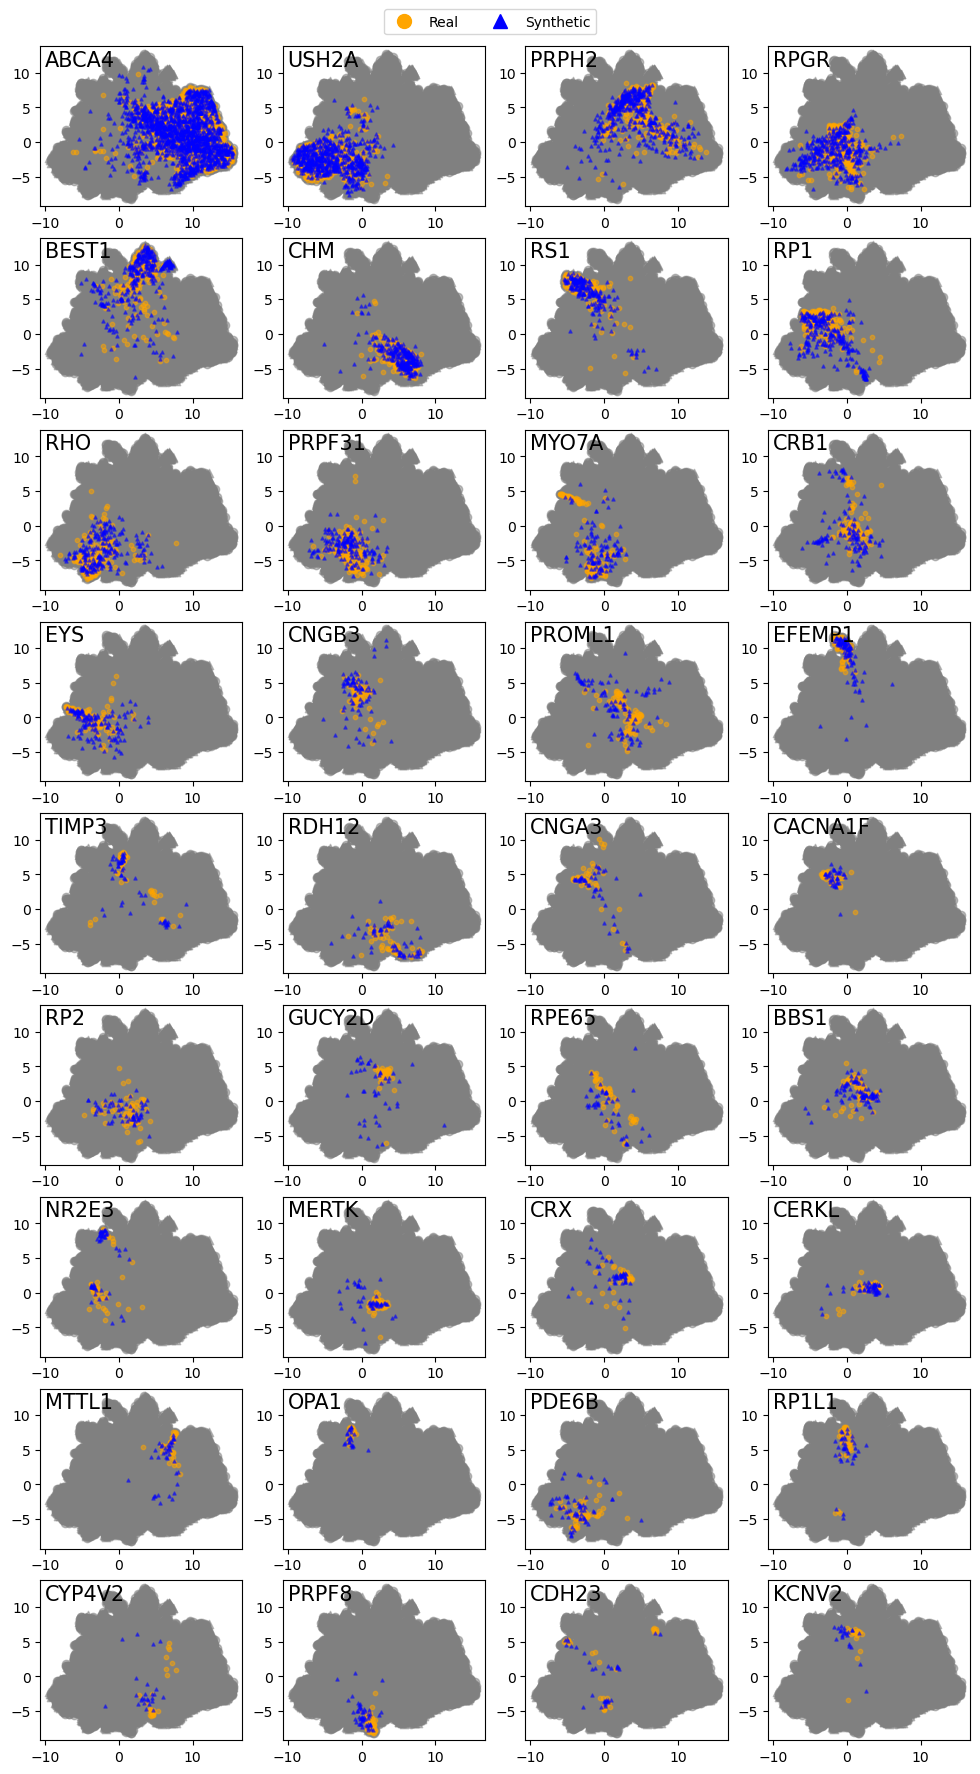

In [158]:
n = 20
m = 0.99

i = n_neighbors.index(n)
j = min_dist.index(m)

# grab embeddings
embed = embeddings[i, j]

# separate into real vs synthetic
real_embeddings, synthetic_embeddings = embed[:len(real_features)], embed[len(real_features):]

real_labels = np.array([real_dataset.class2idx[i] for i in real_dataset.img_labels])
synthetic_labels = np.array([synthetic_dataset.class2idx[i] for i in synthetic_dataset.img_labels])
with open("classes.txt") as f:
    target_names = f.read().splitlines()
target_ids = list(real_dataset.class2idx[name] for name in target_names)
assert len(target_names) == len(target_ids)
assert real_embeddings.shape[0] == len(real_labels)
assert synthetic_embeddings.shape[0] == len(synthetic_labels)

l = 1
plt.figure(figsize=(12, 22))
for k, label in zip(target_ids, target_names):
    
    # plot the full manifold
    plt.subplot(9, 4, l)
#     plt.title("Gene: {}".format(label), y=1.08)
    plt.text(-10, 11, label, fontsize=15)
    plt.scatter(real_embeddings[:, 0], real_embeddings[:, 1], c="grey", marker="o", alpha=0.5)
    plt.scatter(synthetic_embeddings[:, 0], synthetic_embeddings[:, 1], c="grey", marker="^", alpha=0.5)
    
    # plot just highlighted gene region on manifold
    plt.scatter(real_embeddings[real_labels == k, 0], real_embeddings[real_labels == k, 1], c="orange", marker="o", alpha=0.5, s=10)
    plt.scatter(synthetic_embeddings[synthetic_labels == k, 0], synthetic_embeddings[synthetic_labels == k, 1], c="blue", marker="^", alpha=0.5, s=5)
    l += 1
    
import matplotlib.lines as mlines
orange_circle = mlines.Line2D([], [], color="orange", marker="o", linestyle="None", markersize=10, label="Real")
blue_triangle = mlines.Line2D([], [], color="blue", marker="^", linestyle="None", markersize=10, label="Synthetic")
plt.figlegend(handles=[orange_circle, blue_triangle], ncol=2, loc="upper center", bbox_to_anchor=(0.5, 0.9))

# plt.suptitle("Real vs Synthetic Image Visualizations in Lower Dimensional Space", bbox_to_anchor=(0.5, 1))
plt.show()
plt.tight_layout()
plt.close()

## Clustering Distance Measurement

In [ ]:
# distance between synthetic and real clusters
mean_real = np.mean(real_features_2d, axis=0)
mean_synth = np.mean(synthetic_features_2d, axis=0)
var_real = np.var(real_features_2d, axis=0)
var_synth = np.var(synthetic_features_2d, axis=0)

centroid_distance = np.linalg.norm(mean_real - mean_synth)
print(centroid_distance, var_real, var_synth)

In [ ]:
y = np.array([real_dataset.class2idx[i] for i in real_dataset.img_labels])
y_synth = np.array([synthetic_dataset.class2idx[i] for i in synthetic_dataset.img_labels])
target_names = list(real_dataset.class2idx.keys())
target_ids = list(real_dataset.class2idx.values())
assert len(target_names) == len(target_ids)
assert real_features_2d.shape[0] == len(y)
assert synthetic_features_2d.shape[0] == len(y_synth)

centroid_distances = []
for i, label in zip(target_ids, target_names):
    r_mean = np.mean(real_features_2d[y == i, :], axis=0)
    s_mean = np.mean(synthetic_features_2d[y_synth == i, :], axis=0)
    centroid_distances.append(np.linalg.norm(r_mean - s_mean))

plt.figure(figsize=(12, 6))
plt.bar(x=target_names, height=centroid_distances)
plt.show()
plt.close()

In [ ]:
# embed the real dataset in 2D
def run_dim_reduce(data, n_components=2, method="tsne", transform=False, random_state=1399, **extra_params):

    if method == "umap":
        import umap
        n_neighbours = extra_params["n_neighbors"] if "n_neighbors" in extra_params.keys() else 15
        min_dist = extra_params["min_dist"] if "min_dist" in extra_params.keys() else 0.1

        print("Fitting Dataset")
        mapper = umap.UMAP(n_neighbors=n_neighbours, min_dist=min_dist, random_state=random_state, n_components=n_components)
        if isinstance(data, torch.utils.data.dataloader.DataLoader):
            for _, _, x, _ in tqdm(real_dataloader):
                x = x.view(len(x), -1).numpy()
                mapper.fit(x)
        else:
            mapper.fit(data)

    else:
        from sklearn.manifold import TSNE
        print("Fitting Dataset")
        mapper = TSNE(n_components=n_components, init='random', random_state=random_state)
        if isinstance(data, torch.utils.data.dataloader.DataLoader):
            for _, _, x, _ in tqdm(real_dataloader):
                x = x.view(len(x), -1).numpy()
                mapper.fit(x)

    if transform:
        print("Transforming Dataset")
        if isinstance(data, torch.utils.data.dataloader.DataLoader):
            embeddings = []
            for _, _, x, y in real_dataloader:
                embeddings.append(mapper.transform(x.view(len(x), -1)))
            embeddings = np.concatenate(embeddings)
        else:
            embeddings = mapper.fit_transform(np.float32(data))

        return (mapper, embeddings)
    else:
        return mapper